In [1]:
import pandas as pd
import re
import sys
import numpy as np
import import_ipynb
import cred
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import matplotlib.pyplot as plt
from skimage import io
from sklearn.metrics.pairwise import cosine_similarity

importing Jupyter notebook from cred.ipynb


### Data Exploration: Tracklist Dataset 

In [2]:
spotify_df = pd.read_csv('dataset.csv')
spotify_df.shape

(114000, 21)

In [3]:
spotify_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [4]:
spotify_df = spotify_df.drop('Unnamed: 0', axis = 1)

In [5]:
spotify_df.head()

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

In [6]:
spotify_df['track_genre'].value_counts()

acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: track_genre, Length: 114, dtype: int64

In [7]:
spotify_df['popularity'].describe()

count    114000.000000
mean         33.238535
std          22.305078
min           0.000000
25%          17.000000
50%          35.000000
75%          50.000000
max         100.000000
Name: popularity, dtype: float64

dataset: https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset <br>
**Conclusions:** <br>
- 114,000 songs

- 3 columns have 1 NULL value.  Since TF-DIF vectorizer does not support NULL values, these will be dropped in the TF-IDF dataframe step. Replacing NULL values with an empty string to limit the number ofr dropped values would be an alternative solution.  However, there is only 1 row that needs to be dropped, so it does not impact the loss of data.  Additionally, TF-IDF vectorization is a frequency based measure of similarity, replacing NULL values with empty strings would technically consider these songs to be similar, which is not an accurate assumption.     

- **observation:** the distribution for song genres is balanced.  There are 1000 songs within each genre. 

- let's convert 'explicit' column to 0 & 1 for numerical consistency 

- let's also create bins for 'popularity' so they can be OHE for TF-IDF. Popularity is from range 0-100 inclusive. Therefore, let's make bins of range 5 


#### Converting 'explicit' columns to 0, 1

In [8]:
spotify_df['explicit'] = spotify_df['explicit'].apply(lambda x: 1 if x == 'True' else 0)

In [9]:
spotify_df.head()

track_id                 artists  \
0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666         0   
1            Ghost - Acoustic          55       149610         0   
2              To Begin Again          57       210826         0   
3  Can't Help Falling In Love          71       201933         0   
4                     Hold On          82       198853         0   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

### Creating the TF-IDF Vectorized Dataframe 

- The only values that will be included in the final feature set df are the numerical data.  ID will be added as the last column after the numerical values have been TF-IDF converted for matching purposes 

- Since genre is an important feature for song generation, as genre dataframe will be created.  Genre values are not numerical, therefore TF-IDF vectorization will be utilized here to create numerical values for a song's genre 

- Popularity will be binned as mentioned above 

- normalization for all numeric values (minus genre since TF-IDF vectorization takes care of this for us)

#### One-Hot Encoding function 

In [10]:
def ohe_feature(df, col, prefix): 
    x = pd.get_dummies(df[col], prefix=prefix) 
    
    return x
 

#### Binning Popularity feature  

In [11]:
spotify_df['pop_bins'] = pd.cut(spotify_df['popularity'], 20, labels=range(20))
spotify_df = spotify_df.drop_duplicates(subset=['artists', 'track_name'])
spotify_df

track_id                 artists  \
0       5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1       4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2       1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3       6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4       5vjLSffimiIP26QG5WcN2K        Chord Overstreet   
...                        ...                     ...   
113995  2C3TZjDRiAzdyViavDJ217           Rainy Lullaby   
113996  1hIz5L4IB9hN3WRYPOCGPw           Rainy Lullaby   
113997  6x8ZfSoqDjuNa5SVP5QjvX           Cesária Evora   
113998  2e6sXL2bYv4bSz6VTdnfLs        Michael W. Smith   
113999  2hETkH7cOfqmz3LqZDHZf5           Cesária Evora   

                                               album_name  \
0                                                  Comedy   
1                                        Ghost (Acoustic)   
2                                          To Begin Again   
3       Crazy Rich Asians (Original Motion Picture Sou...   
4                                                 Hold On   
...                                                   ...   
113995  #mindfulness - Soft Rain for Mindful Meditatio...   
113996  #mindfulness - Soft Rain for Mindful Meditatio...   
113997                                            Best Of   
113998                                  Change Your World   
113999                                     Miss Perfumado   

                        track_name  popularity  duration_ms  explicit  \
0                           Comedy          73       230666         0   
1                 Ghost - Acoustic          55       149610         0   
2                   To Begin Again          57       210826         0   
3       Can't Help Falling In Love          71       201933         0   
4                          Hold On          82       198853         0   
...                            ...         ...          ...       ...   
113995         Sleep My Little Boy          21       384999         0   
113996            Water Into Light          22       385000         0   
113997              Miss Perfumado          22       271466         0   
113998                     Friends          41       283893         0   
113999                   Barbincor          22       241826         0   

        danceability  energy  key  ...  mode  speechiness  acousticness  \
0              0.676  0.4610    1  ...     0       0.1430        0.0322   
1              0.420  0.1660    1  ...     1       0.0763        0.9240   
2              0.438  0.3590    0  ...     1       0.0557        0.2100   
3              0.266  0.0596    0  ...     1       0.0363        0.9050   
4              0.618  0.4430    2  ...     1       0.0526        0.4690   
...              ...     ...  ...  ...   ...          ...           ...   
113995         0.172  0.2350    5  ...     1       0.0422        0.6400   
113996         0.174  0.1170    0  ...     0       0.0401        0.9940   
113997         0.629  0.3290    0  ...     0       0.0420        0.8670   
113998         0.587  0.5060    7  ...     1       0.0297        0.3810   
113999         0.526  0.4870    1  ...     0       0.0725        0.6810   

        instrumentalness  liveness  valence    tempo  time_signature  \
0               0.000001    0.3580   0.7150   87.917               4   
1               0.000006    0.1010   0.2670   77.489               4   
2               0.000000    0.1170   0.1200   76.332               4   
3               0.000071    0.1320   0.1430  181.740               3   
4               0.000000    0.0829   0.1670  119.949               4   
...                  ...       ...      ...      ...             ...   
113995          0.928000    0.0863   0.0339  125.995               5   
113996          0.976000    0.1050   0.0350   85.239               4   
113997          0.000000    0.0839   0.7430  132.378               4   
113998          0.000000    0.2700   0.4130  135.960               4   
113999          0.0000

#### Creating the TF-IDF dataframe 

In [12]:
def tfidf_df(df): 
    
    # tf-idf df for genre
    vec = TfidfVectorizer()
    X = vec.fit_transform(spotify_df['track_genre'])
    feature_names = ['genre' + '_' + i for i in vec.get_feature_names_out()]
    dense = X.todense()
    dense_list = dense.tolist()
    genre_df = pd.DataFrame(dense_list, columns=feature_names)
    
    # one-hot-encoding features df
    popularity = ohe_feature(df,'pop_bins', 'pop')
    
    # normalizing spotify_df numeric values
    spotify_df_slice = df.iloc[:, 5:19]
    norm = MinMaxScaler()
    Z = norm.fit_transform(spotify_df_slice)
    fn = norm.get_feature_names_out()
    scaled_df = pd.DataFrame(Z, columns=fn)
    
    
    # concatinating dfs 
    complete_feature_df = pd.concat([genre_df, popularity, scaled_df], axis = 1)
           
    
    # adding id column 
    complete_feature_df['track_id'] = df.iloc[:, 0]
    complete_feature_df = complete_feature_df.dropna().drop_duplicates(subset=['track_id'])
    
    
    return complete_feature_df

In [13]:
spotify_tfidf = tfidf_df(spotify_df)
spotify_tfidf

genre_acoustic  genre_afrobeat  genre_age  genre_alt  \
0                 1.0             0.0        0.0        0.0   
1                 1.0             0.0        0.0        0.0   
2                 1.0             0.0        0.0        0.0   
3                 1.0             0.0        0.0        0.0   
4                 1.0             0.0        0.0        0.0   
...               ...             ...        ...        ...   
81316             0.0             0.0        0.0        0.0   
81317             0.0             0.0        0.0        0.0   
81318             0.0             0.0        0.0        0.0   
81320             0.0             0.0        0.0        0.0   
81342             0.0             0.0        0.0        0.0   

       genre_alternative  genre_ambient  genre_and  genre_anime  genre_bass  \
0                    0.0            0.0        0.0          0.0         0.0   
1                    0.0            0.0        0.0          0.0         0.0   
2                    0.0            0.0        0.0          0.0         0.0   
3                    0.0            0.0        0.0          0.0         0.0   
4                    0.0            0.0        0.0          0.0         0.0   
...                  ...            ...        ...          ...         ...   
81316                0.0            0.0        0.0          0.0         0.0   
81317                0.0            0.0        0.0          0.0         0.0   
81318                0.0            0.0        0.0          0.0         0.0   
81320                0.0            0.0        0.0          0.0         0.0   
81342                0.0            0.0        0.0          0.0         0.0   

       genre_black  ...  loudness  mode  speechiness  acousticness  \
0              0.0  ...  0.791392   0.0     0.148187      0.032329   
1              0.0  ...  0.597377   1.0     0.079067      0.927711   
2              0.0  ...  0.736123   1.0     0.057720      0.210843   
3              0.0  ...  0.573701   1.0     0.037617      0.908635   
4              0.0  ...  0.737103   1.0     0.054508      0.470884   
...            ...  ...       ...   ...          ...           ...   
81316          0.0  ...  0.437212   1.0     0.031813      0.856426   
81317          0.0  ...  0.385439   1.0     0.038756      0.878514   
81318          0.0  ...  0.774134   1.0     0.034197      0.050100   
81320          0.0  ...  0.800603   0.0     0.039793      0.001827   
81342          0.0  ...  0.714759   1.0     0.030777      0.382530   

       instrumentalness  liveness   valence     tempo  time_signature  \
0              0.000001    0.3580  0.718593  0.361245             0.8   
1              0.000006    0.1010  0.268342  0.318397             0.8   
2              0.000000    0.1170  0.120603  0.313643             0.8   
3              0.000071    0.1320  0.143719  0.746758             0.6   
4              0.000000    0.0829  0.167839  0.492863             0.8   
...                 ...       ...       ...       ...             ...   
81316          0.851000    0.1140  0.064221  0.327297             0.8   
81317          0.904000    0.1290  0.047739  0.470773             0.8   
81318          0.000000    0.7290  0.189950  0.401353             0.8   
81320          0.000000    0.3260  0.466332  0.525948             0.8   
81342          0.000000    0.2700  0.415075  0.558651             0.8   

                     track_id  
0      5SuOikwiRyPMVoIQDJUgSV  
1      4qPNDBW1i3p13qLCt0Ki3A  
2      1iJBSr7s7jYXzM8EGcbK5b  
3      6lfxq3CG4xtTiEg7opyCyx  
4      5vjLSffimiIP26QG5WcN2K  
...                       ...  
81316  53S98SFeRSxjd7F7eUnfAJ  
81317  1JyC0QIAcBdBZPtrv1glty  
81318  1i5nDFmDSi8Q3UPRVnbc03  
81320  7eLvCsLfaeSHeezjOwJ96E  
81342  7cC4Y0jQZ4eRoRqRQIau1x  

[61358 rows x 149 columns]

### Connect to Spotify API 

resources: <br>
https://spotipy.readthedocs.io/en/2.22.0/#examples <br>
https://developer.spotify.com/documentation/general/guides/authorization/code-flow/



**A brief intro to APIs (this is my first time working with an API)**: <br>

Application Programming Interface <br> 
- Allows different programs to communicate to one another
- It is an interface that provides a set of functions to the user where the implementation is hidden (what goes on under the hood)
- Client = caller of API
- Server = respondent of API 
- It is a messanger system waiting for requests 

Spotify Scope: are used to determine exactly what the user will be doing; nothing more, nothing less.  In this case, we are just reading the users' library.  This needs to **defined** <br>

resource: https://developer.spotify.com/documentation/general/guides/authorization/scopes/

In [14]:
scope = 'user-library-read'

In [15]:
# This is only needed if the 'current_'user_playlist is not being used. 
# for example sp.user_playlists(USERNAME) would be accepted as the argument 
#if len(sys.argv) > 1: 
    #username = sys.argv[1]
#else: 
    #print('Username needed')
    #print(f'Usage: {sys.argv[0],}')
    #sys.exit()       


These pieces of code proves to the authorization server (Spotify) that the client requesting a token is permitted to do so.  It enables the client to obtain authorized access to spotify's protected wed API 

**auth_manager:** this expects the client id and client secret arguments and it used to create the auth_manager variable that can be passed to the sp instance of the spotify class

**sp:** this is an instance created for the Spotify class to authenticate requests. These needs to be done before making requests to Spotify's API  

In [16]:
auth_manager = SpotifyClientCredentials(client_id=cred.CLIENT_ID, client_secret=cred.CLIENT_SECRET)


sp = spotipy.Spotify(auth_manager=auth_manager)


The token is created which expects scope, client id, client secret, and redirect url. This token is then passed as the value for 'auth' in another sp instance created for the Spotify class needed to access different functions 

In [17]:
token = util.prompt_for_user_token(scope, client_id=cred.CLIENT_ID, client_secret=cred.CLIENT_SECRET, 
                                   redirect_uri=cred.REDIRECT_URI)

In [18]:
sp = spotipy.Spotify(auth=token)

In [19]:
id_name = {}
for i in sp.current_user_playlists()['items']:
    id_name[i['name']] = i['uri'].split(':')[2]

### Extract data from spotify user's playlist and return a df

The df that will be returned will include tracks that are in the user's playlist & the spotify_df <br>
This will ensure that when creating the playlist vector, the user's playlist can grab numeric info from the tf-idf df that was created based on the spotify_df 


In [21]:
def get_playlist_info(id_dic, playlist_name, df):

    
    personal_playlist = pd.DataFrame()

    # ix needed to create index for new df (playlist)
    #.loc[row_indexer,col_indexer] = value
    for ix, i in enumerate(sp.playlist_tracks(id_dic[playlist_name])['items']):
        personal_playlist.loc[ix, 'track_name'] = i['track']['name'] # name of song
        personal_playlist.loc[ix, 'artist_name'] = i['track']['artists'][0]['name'] # artist name
        personal_playlist.loc[ix, 'track_id'] = i['track']['id'] # song id
        personal_playlist.loc[ix, 'url'] = i['track']['album']['images'][0]['url'] # url to display album artwork 
        #personal_playlist.loc[ix, 'date_added'] = i['added_at'] # date user added song
        
    #converting date_added from object to datetime datatype 
    #personal_playlist['date_added'] = pd.to_datetime(personal_playlist['date_added'])
    
    # checking to see if the songs in the user's playlist are present in the spotify_df
    personal_playlist = personal_playlist[personal_playlist['track_id'].isin(df['track_id'])]#.sort_values('date_added', ascending = False)
    
    return personal_playlist
        
    
       
         
        
     

In [27]:
playlist = get_playlist_info(id_name, 'keeping kass kool', spotify_df)
print(playlist.shape)
playlist

(22, 4)


track_name          artist_name  \
7                                   Kilby Girl  The Backseat Lovers   
13                                   About You             The 1975   
20                                 Oh Caroline             The 1975   
21                        Come a Little Closer    Cage The Elephant   
22                        I'm In Love With You             The 1975   
23                                    Pyramids          Frank Ocean   
24  Nothing More To Say (with 6LACK & Donae’o)        Calvin Harris   
34                       Love It If We Made It             The 1975   
40                          Walking On A Dream    Empire of the Sun   
50                                   The Dress                Dijon   
53                   I Didn't Change My Number        Billie Eilish   
54                           Billie Bossa Nova        Billie Eilish   
55                                    Oxytocin        Billie Eilish   
62                                       Woman             Doja Cat   
63                                Need to Know             Doja Cat   
73                                    Novacane          Frank Ocean   
78                            Thinkin Bout You          Frank Ocean   
81                         Cigarette Daydreams    Cage The Elephant   
93                                        Lost          Frank Ocean   
94                                         Ivy          Frank Ocean   
95                                      Chanel          Frank Ocean   
96                                Self Control          Frank Ocean   

                  track_id                                                url  
7   1170VohRSx6GwE6QDCHPPH  https://i.scdn.co/image/ab67616d0000b273838679...  
13  1fDFHXcykq4iw8Gg7s5hG9  https://i.scdn.co/image/ab67616d0000b2731f44db...  
20  14dJexYlvd3t3XAtD1pYW1  https://i.scdn.co/image/ab67616d0000b2731f44db...  
21  4sebUbjqbcgDSwG6PbSGI0  https://i.scdn.co/image/ab67616d0000b273fb1cb9...  
22  0uBdQzKghx88d2Lp8SLFKJ  https://i.scdn.co/image/ab67616d0000b273985513...  
23  4QhWbupniDd44EDtnh2bFJ  https://i.scdn.co/image/ab67616d0000b2737aede4...  
24  4hvWEdTLJxrZsDDjUEcHvy  https://i.scdn.co/image/ab67616d0000b273c5844a...  
34  6WmIyn2fx1PKQ0XDpYj4VR  https://i.scdn.co/image/ab67616d0000b2736c5820...  
40  5r5cp9IpziiIsR6b93vcnQ  https://i.scdn.co/image/ab67616d0000b273f3aa0e...  
50  0YMe6PHRbeDcN7KJdCG0bW  https://i.scdn.co/image/ab67616d0000b273a68442...  
53  7bcy34fBT2ap1L4bfPsl9q  https://i.scdn.co/image/ab67616d0000b2732a038d...  
54  2KnuaZYoGzDoHiBTNYOTXG  https://i.scdn.co/image/ab67616d0000b2732a038d...  
55  4t2OeILB07eMGTXSUbMPEu  https://i.scdn.co/image/ab67616d0000b2732a038d...  
62  6Uj1ctrBOjOas8xZXGqKk4  https://i.scdn.co/image/ab67616d0000b2734df324...  
63  3Vi5XqYrmQgOYBajMWSvCi  https://i.scdn.co/image/ab67616d0000b2734df324...  
73  4osgfFTICMkcGbbigdsa53  https://i.scdn.co/image/ab67616d0000b27359a428...  
78  7DfFc7a6Rwfi3YQMRbDMau  https://i.scdn.co/image/ab67616d0000b2737aede4...  
81  2tznHmp70DxMyr2XhWLOW0  https://i.scdn.co/image/ab67616d0000b273fb1cb9...  
93  3GZD6HmiNUhxXYf8Gch723  https://i.scdn.co/image/ab67616d0000b2737aede4...  
94  2ZWlPOoWh0626oTaHrnl2a  https://i.scdn.co/image/ab67616d0000b273c5649a...  
95  6Nle9hKrkL1wQpwNfEkxjh  https://i.scdn.co/image/ab67616d0000b273a0b780...  
96  5GUYJTQap5F3RDQiCOJhrS  https://i.scdn.co/image/ab67616d0000b273c5649a...

### Create a playlist vector 

- the playlist vector will consist of a single row with the same number of columns as the tf_idf dataframe 
- this vector will be used to compare with other tracks (rows) vectors in the tf-idf datafram using cosine similarity
- a dataframe of songs that are NOT on the user's playlist will be created and retured from the tf-idf datafram to ensure that recommendations are not already present on the user's playlist 

In [28]:
def playlist_vector(tfidf_df, playlist_df):
    
    playlist_vec = tfidf_df[tfidf_df['track_id'].isin(playlist_df['track_id'])]
    # a tf-idf dataframe that does not contain songs within a user's playlist 
    notin_user_playlist = tfidf_df[~tfidf_df['track_id'].isin(playlist_df['track_id'])]
    return playlist_vec.sum(axis = 0, numeric_only=True), notin_user_playlist
    

In [29]:
user_playlist_vector, not_user_playlist = playlist_vector(spotify_tfidf, playlist)

## Generating Recommendations 
### Cosine Similarity 

In [30]:
def generate_recs(df, notin_playlist_df, playlist_vec): 
    
    notin_spotify_df = df[df['track_id'].isin(notin_playlist_df['track_id'])].drop_duplicates(subset=['track_id'])
    notin_spotify_df['cos_sim'] =  cosine_similarity(notin_playlist_df.drop('track_id', axis = 1), 
                  playlist_vec.values.reshape(1, -1), dense_output=True)
    top_40 = notin_spotify_df.nlargest(40, 'cos_sim')
    top_40['url'] = top_40['track_id'].apply(lambda x: sp.track(x)['album']['images'][0]['url'])

    return top_40.drop_duplicates(subset=['track_id'])

In [31]:
top_40 = generate_recs(spotify_df, not_user_playlist, user_playlist_vector)
top_40

track_id                               artists  \
2457   1jJci4qxiYcOHhQR247rEU                                  MGMT   
2471   7x8dCjCr0x6x2lXKujYD34                          Foo Fighters   
2305   1LzNfuep1bnAUR9skqdHCK                            Mazzy Star   
2404   1G391cbiT3v3Cywg8T7DM1                 Red Hot Chili Peppers   
2100   2u0CelO5c81XS7z3dGpHbS                     The Neighbourhood   
2300   0EfsDEYaSjGYd66Pr881nq                     The Neighbourhood   
2366   59WN2psjkt1tyaxjspN8fp              Rage Against The Machine   
2402   64BbK9SFKH2jk86U3dGj2P                 Red Hot Chili Peppers   
2304   0KzAbK6nItSqNh8q70tb0K                                Pixies   
2306   46gSk82duJtX3TTA182ruG                       Franz Ferdinand   
2008   6rrKbzJGGDlSZgLphopS49                             The Score   
2355   6G8xvLFNkXy3HM5EbQI6c8                         lovelytheband   
2600   40gvh6jP5qxMJuMmF9lG9A                     The Neighbourhood   
2108   2RsAajgo0g7bMCHxwH3Sk0                               Nirvana   
2307   3TgMcrV32NUKjEG2ujn9eh                              The 1975   
2050   5Q6fh8OEhBYepJaORz9lxe                 The Neighbourhood;Syd   
2200   0GO8y8jQk1PkHzS31d699N                             Grouplove   
2312   57iDDD9N9tTWe75x6qhStw                             The Verve   
2409   5vHLwhxxlGzmClMcxRRFPr                               Nirvana   
2152   5SDcksP8En1l6RtTY1wzHc                  Hillsong UNITED;TAYA   
2405   0gmbgwZ8iqyMPmXefof8Yf                            Nickelback   
8259   2QfiRTz5Yc8DdShCxG1tB2                           Chuck Berry   
2408   2oaK4JLVnmRGIO9ytBE1bt                 Red Hot Chili Peppers   
2406   63OQupATfueTdZMWTxW03A                             Radiohead   
65452  6TBJkXHPhu3EsMk1bshwuI                                 LeeHi   
2360   5W8YXBz9MTIDyrpYaCg2Ky                            Papa Roach   
2363   0eNfURq0r0oNSwFyw1VuVT                              The 1975   
19613  1brnLTvarI9D1hLP6z2Ar8              Kane Brown;Katelyn Brown   
2256   15VRO9CQwMpbqUYA7e6Hwg                               Nirvana   
2558   1jq28NGw6wdtFKx8MBPy6C                            Nickelback   
2368   6Up545NUflOiXo8cEraH49                         Lauren Daigle   
20120  3TcL0dyCMyr0kyTTc4NLgI              Selena Gomez & The Scene   
20159  1rfofaqEpACxVEHIZBJe6W             Camila Cabello;Young Thug   
2101   0VF7YLIxSQKyNiFL3X6MmN                     The Neighbourhood   
2156   0fYVliAYKHuPmECRs1pbRf                         X Ambassadors   
8000   5MAK1nd8R6PWnle1Q1WJvh             Everybody Loves an Outlaw   
2311   7wCmS9TTVUcIhRalDYFgPy                                Pixies   
65084  4ZxOuNHhpyOj4gv52MtQpT                             BLACKPINK   
2010   0AUyNF6iFxMNQsNx2nhtrw                              grandson   
31901  5N5k9nd479b1xpDZ4usjrg  Calvin Harris;Sam Smith;Jessie Reyez   

                                              album_name  \
2457                                Oracular Spectacular   
2471                   Echoes, Silence, Patience & Grace   
2305                         So Tonight That I Might See   
2404                    Californication (Deluxe Edition)   
2100                                          Wiped Out!   
2300                                          Wiped Out!   
2366   Rage Against The Machine - XX (20th Anniversar...   
2402                    Californication (Deluxe Edition)   
2304                                 Death to the Pixies   
2306                                         This fffire   
2008                                               ATLAS   
2355                                           sail away   
2600                                          Wiped Out!   
2108                              Nevermind (Remastered)   
2307           A Brief Inquiry Into Online Relationships   
2050                      Daddy Issues (Remix) feat. Syd   
2200                            Never Trust a Happy Song   
2312                       Ur

In [32]:
def show_top40_images(top_40): 
    
    url_vals = top_40['url']
    plt.figure(figsize=(15,int(0.625 * len(url_vals)))) # creating figure size object
    columns = 5

    for i, url in enumerate(url_vals):
        plt.subplot(int(len(url_vals) / columns + 1), columns, i + 1) # (row, column, index) 

        image = io.imread(url)
        plt.imshow(image)
        plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]) # removing tick marks
        plt.xlabel(top_40['track_name'].values[i], fontsize = 12) # setting x-axis title
        plt.tight_layout() # ensure axis aren't clipped off at figure size 
        #plt.subplots_adjust(wspace=None, hspace=None)


    plt.show()

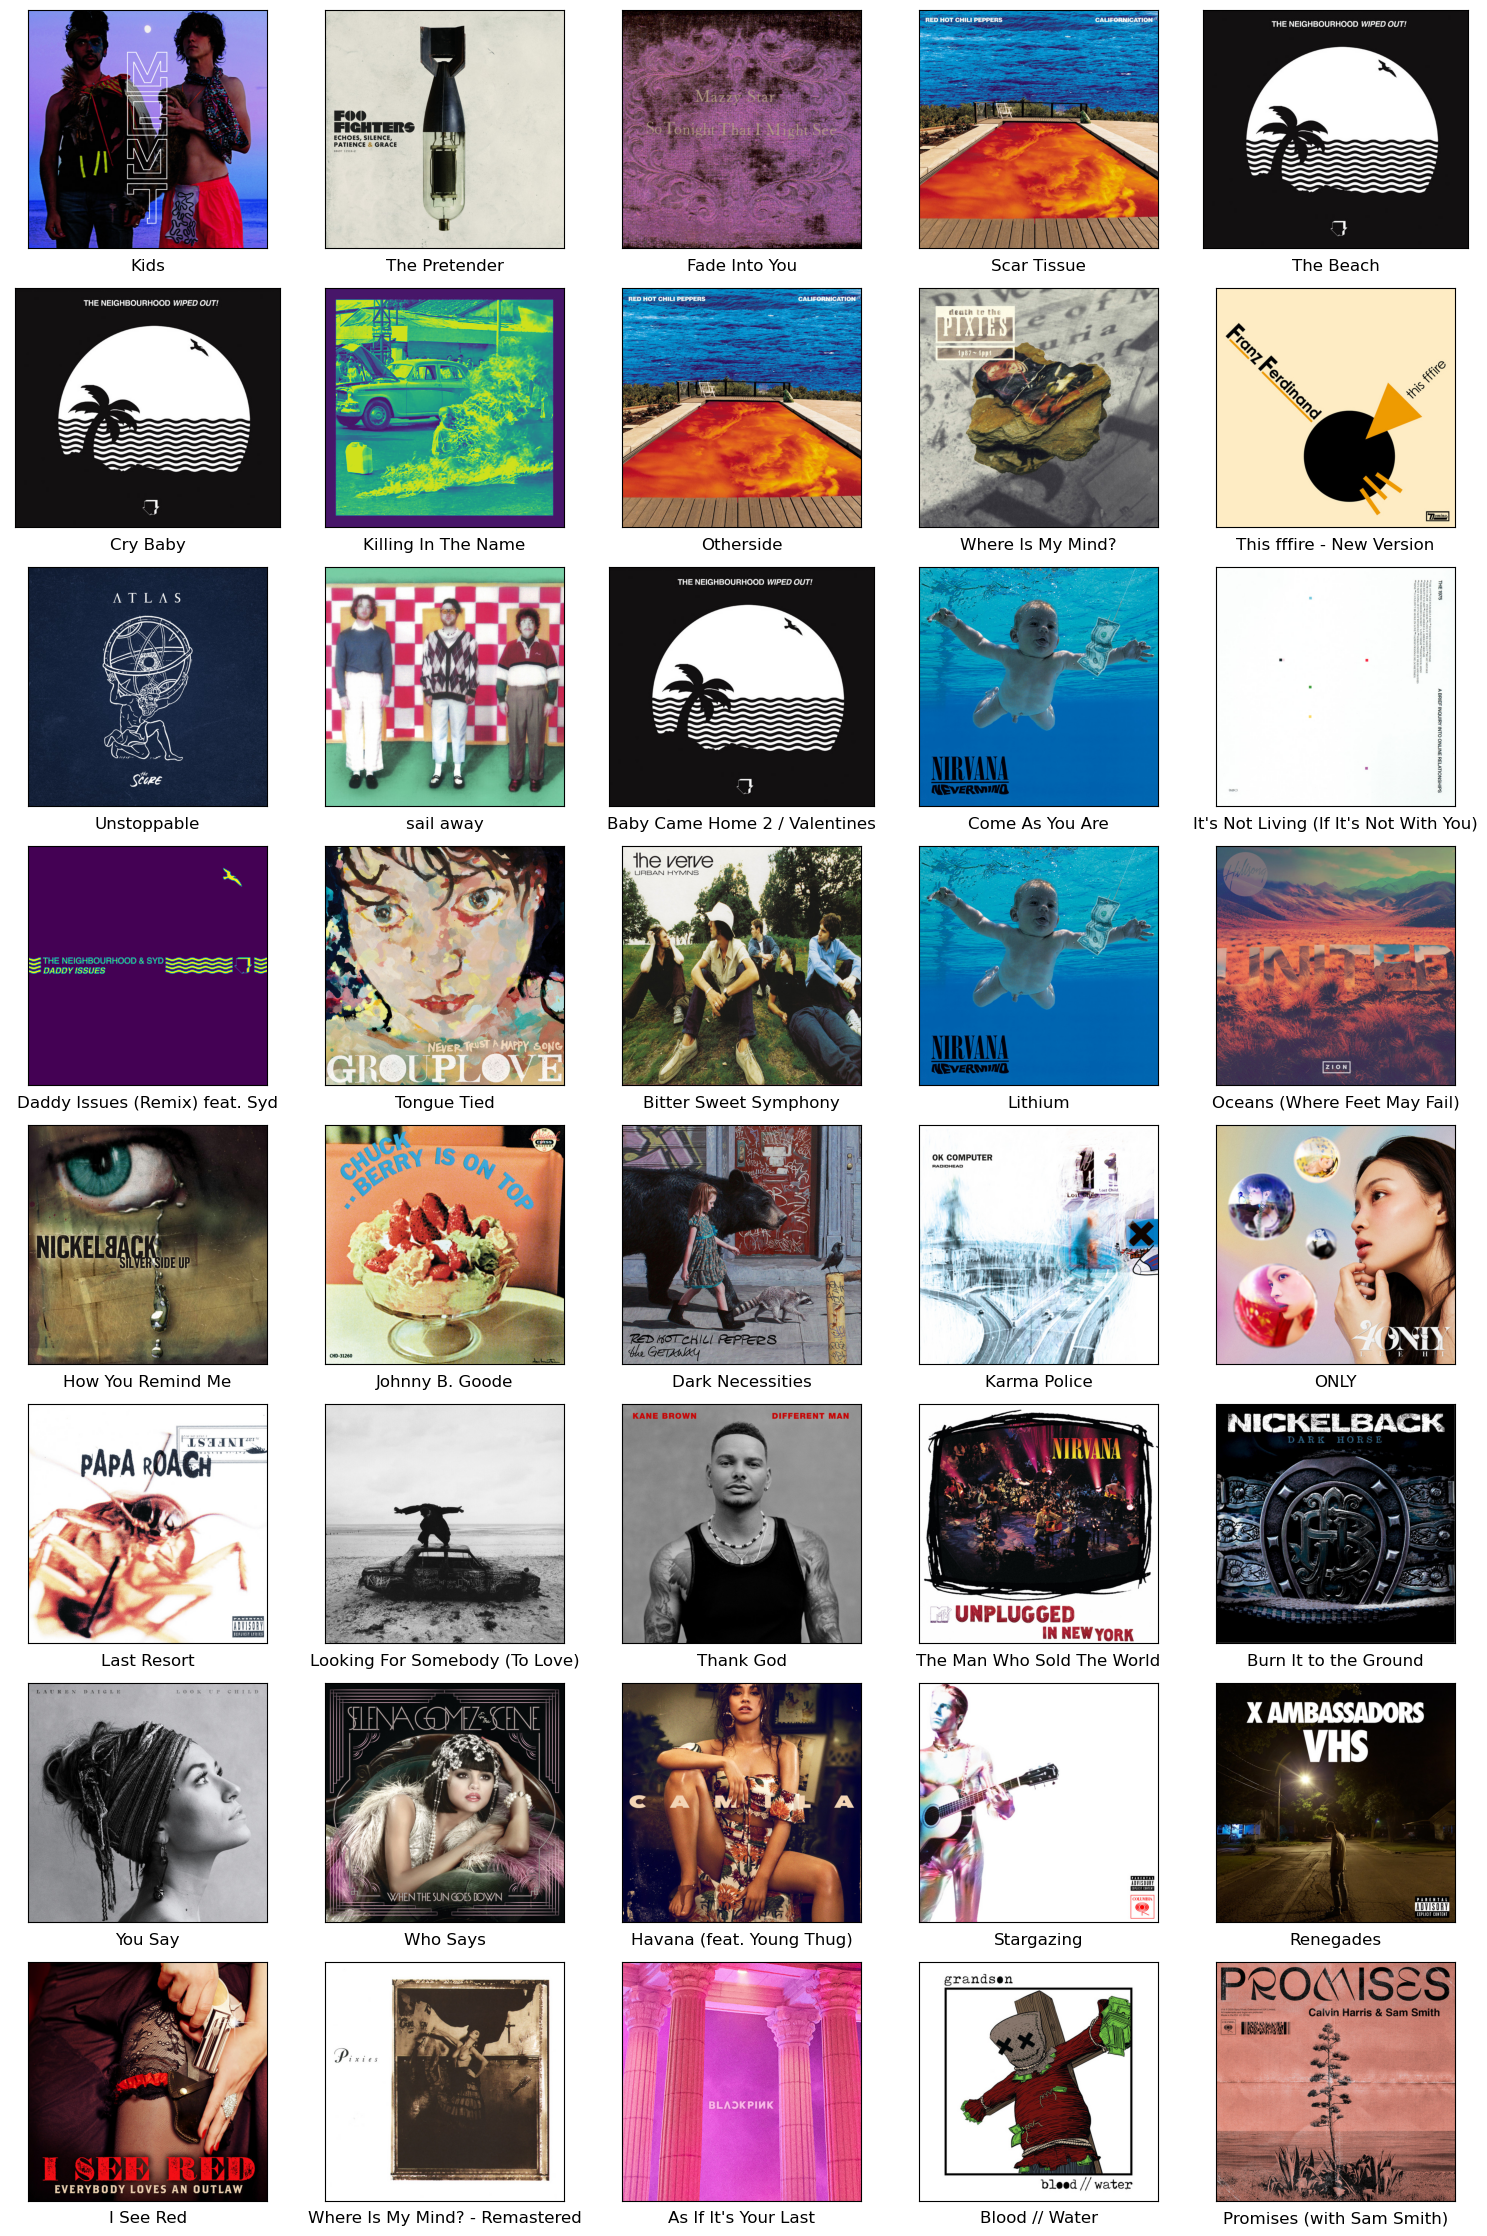

In [33]:
show_top40_images(top_40)

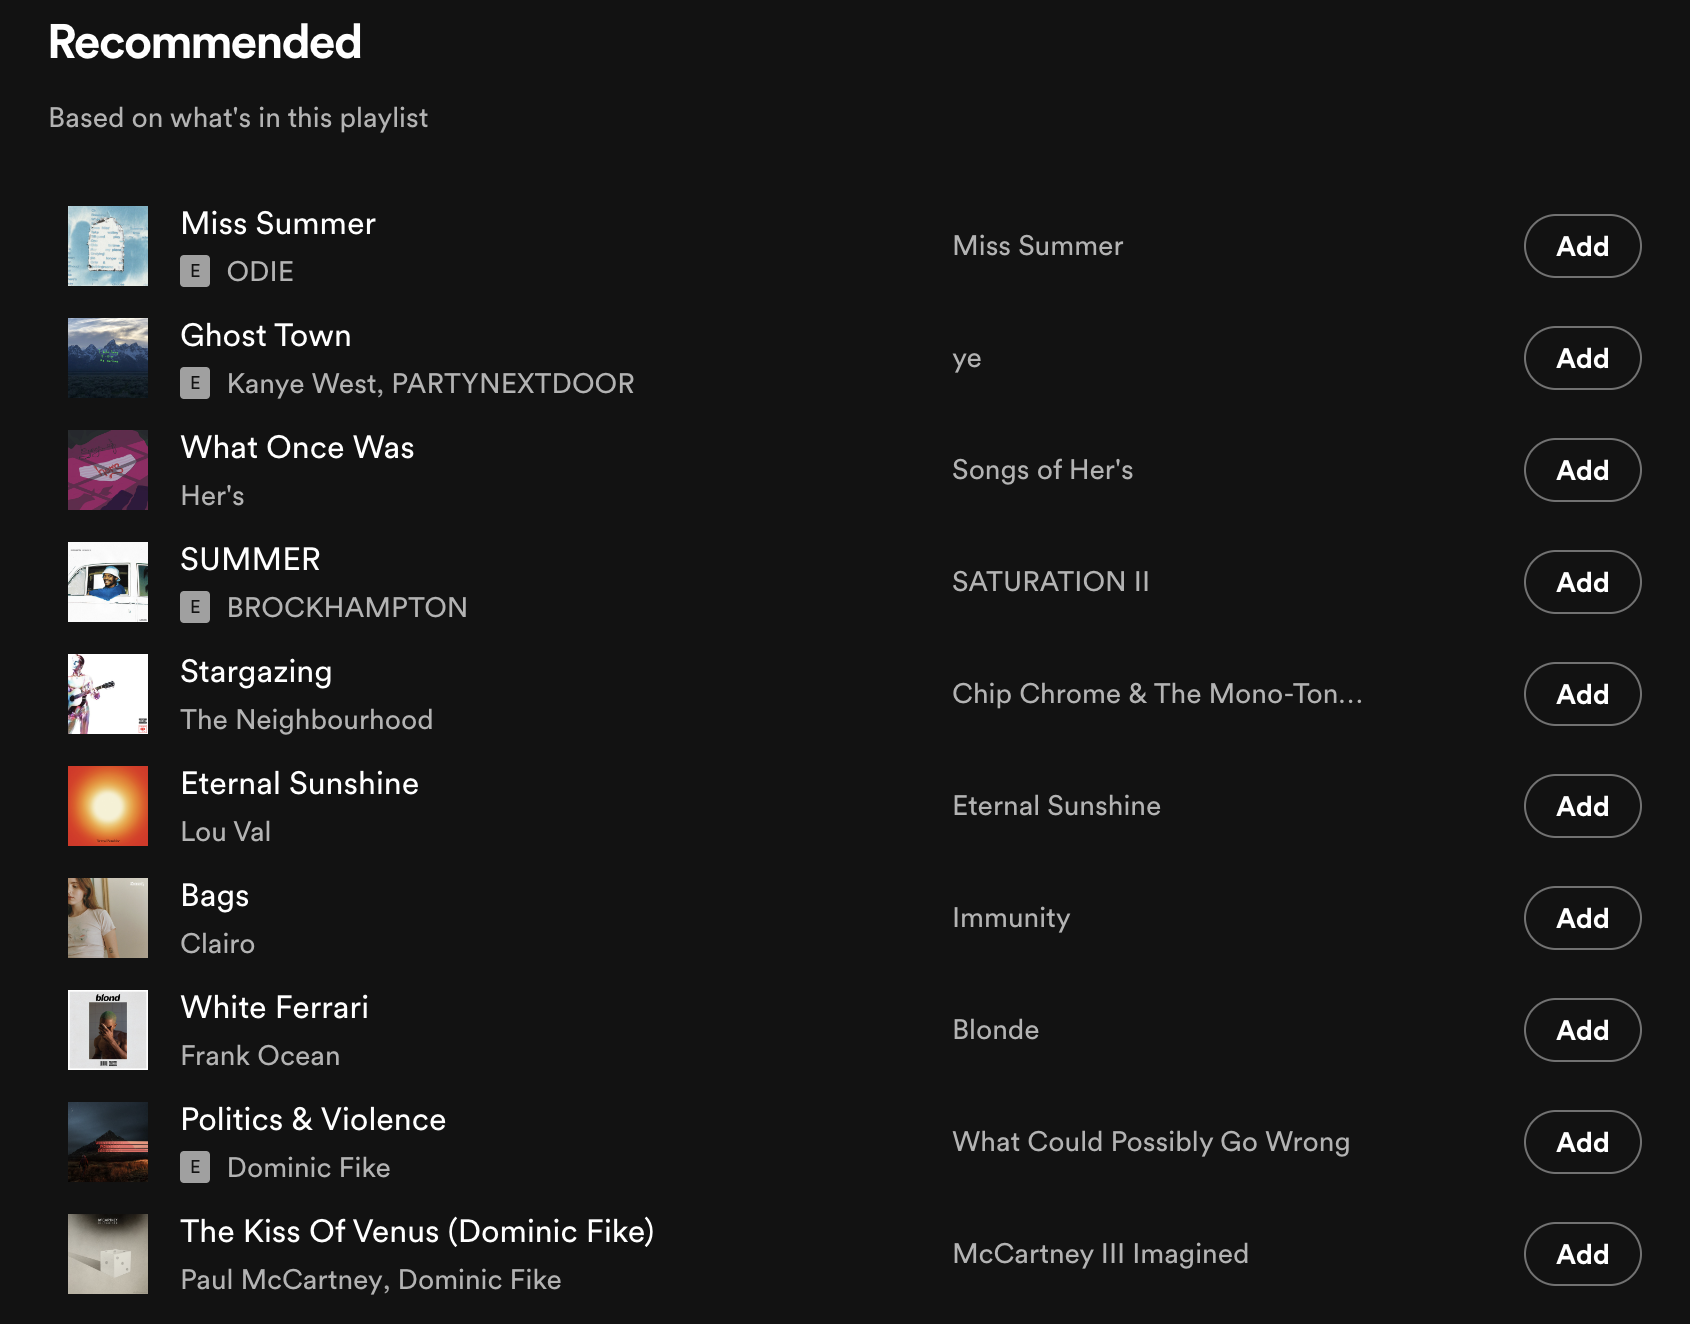

In [34]:
from IPython.display import Image
Image(cred.image_x)

**Conclusions:** <br> 
- Above is a screenshot of a list of recommendations generated by Spotify for this playlist.  My generator and spotify both recommended songs by The Neighbourhood

- Some drawbacks to this niave apprach are the recommendations are limited to what is included in the data set, and not all songs on spotify's library (obviously a huge memory/storage issue for a simple personal project)